# Mental Health Sentiment Analysis | NLP | ML

# Import necessary libraries

In [ ]:
!python --version

Python 3.10.12


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("/content/mental_health.csv")
df.shape

(53043, 3)

In [3]:
df.describe()

,Unnamed: 0
count,53043.000000
mean,26521.000000
std,15312.339501
min,0.000000
25%,13260.500000
50%,26521.000000
75%,39781.500000
max,53042.000000


In [4]:
df.isna().sum()

,0
Unnamed: 0,0
statement,362
status,0


In [5]:
#drop na values
df.dropna(inplace=True)

In [6]:
df.shape

(52681, 3)

In [7]:
df.columns

Index(['Unnamed: 0', 'statement', 'status'], dtype='object')

In [8]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [9]:
#looking at target variable
df['status'].value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


it shows our target variable is imbalanced

# Explore the dataset

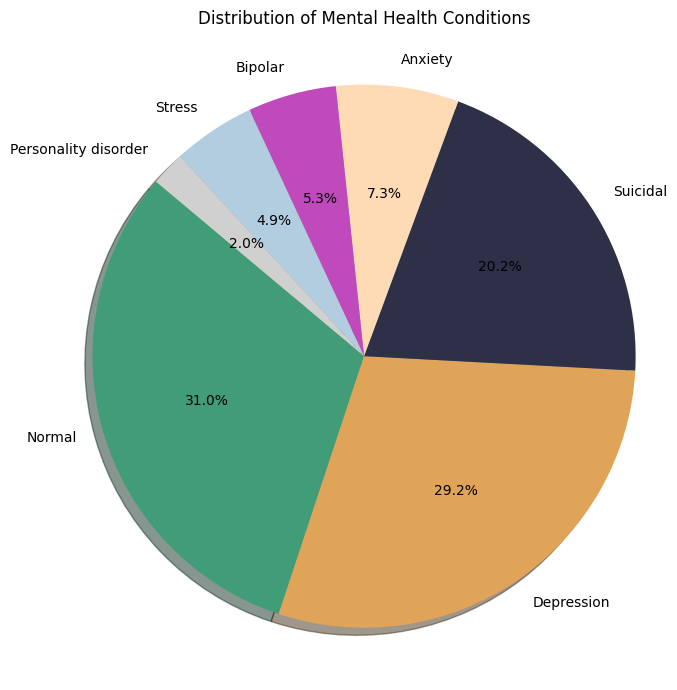

In [10]:
#plot the target to see its distribution using seaborn librarry
#Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

# lets explore the textual data

In [11]:
df['statement'].iloc[2]

'All wrong, back off dear, forward doubt. Stay in a restless and restless place'

In [12]:
#lets group statement with status and randomly 1 will be diplayed
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: just wanted to vent been having a stuffy nose and slight cough these past couple of days, and just a couple hours ago I've been feeling weird with a headache and fatigue. I'm scared I'm going to get sick and throw up later, and I was searching my symptoms up and diabetes is a possible condition, which is something I've thought I had before. To make matters worse, I ate some ice cream and nutella today (when i say some i mean a lot lol rip). I'm also afraid I have heart disease or something because I have a sedentary lifestyle. I've been walking everyday for 30 minutes for the past couple of weeks, but today I skipped because I wasn't feelin it. Just wanted to vent.

Status: Bipolar
Statement: Life has left me hopeless. First, thank you for reading my rant, even if you don't make it to the end...

Life advice please...

30f, relationship with 31m, anf we have a 9mo son.

We lost the home we were renting back in Dec, due to mold. We've been back and forth betwe

In [13]:
#lets add new features len_of_sentences and len_characters based on statements
df['len_of_sentences']=df['statement'].apply(lambda x:len(x.split('.')))
df['len_characters']=df['statement'].apply(lambda x:len(x))

In [14]:
df.head()

,statement,status,len_of_sentences,len_characters
0,oh my gosh,Anxiety,1,10
1,"trouble sleeping, confused mind, restless hear...",Anxiety,2,64
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,2,78
3,I've shifted my focus to something else but I'...,Anxiety,1,61
4,"I'm restless and restless, it's been a month n...",Anxiety,2,72


In [15]:
#lets we explore about long length text data more than 10000
df[df['len_characters']>10000]

,statement,status,len_of_sentences,len_characters
7851,So introduction I guess.. my name is Michael a...,Depression,149,10679
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,1,25302
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,179,11163
10834,I have only 1 person I can somewhat open to bu...,Suicidal,243,27390
11537,"The title is not meant to discourage others, b...",Depression,181,12304
11581,I no longer know what else to do but write thi...,Depression,140,13530
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,96,12819
11831,Sorry this is long but I doubt anyone will eve...,Depression,171,11122
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,1261,32759
18215,I am someone living in Turkey. My age is proba...,Suicidal,199,10219


Conclusion :Mostly long length text show  status depression or scicidal type

# Text Preprocessing

In [16]:
import nltk
import re
from urllib.parse import urlparse
from spacy import load
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [17]:

#tokenization
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')
nltk.download('punkt')
nltk.download('stopwords')
# Download necessary NLTK datasets
nltk.download('punkt_tab')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet2022 to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [18]:

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'your', 'when', 'such', 'can', 'too', 'both', 'ma', 'there', 'his', 'theirs', 'ourselves', "that'll", 'an', 'have', 'over', 'don', 'does', 'same', "weren't", "you've", 'them', 'is', 'was', 'but', 'under', 'how', 'more', "hasn't", 'from', 'who', 'nor', "didn't", 'down', 'why', "couldn't", 'before', 'against', 'whom', 'very', 'on', 'hers', 'while', 'myself', 'do', 'any', 'yours', 'as', "you'll", 'you', 'or', 'now', "hadn't", "shan't", 'by', 'our', 'during', 'and', 'in', 'what', 'those', "isn't", 'of', 'doing', 'herself', "mightn't", 'its', 'hasn', 'she', 'ain', 'so', "don't", 'themselves', 've', "it's", 'just', 'they', 'these', 'weren', 'because', 'that', "won't", 'her', 'him', 't', 'here', 'it', 'where', 'out', "she's", 'won', 'didn', 'other', "wouldn't", 'not', "aren't", 'to', 'o', "you'd", 'had', 'a', 'been', 'own', "doesn't", 'm', 'further', 'for', 'which', 'wouldn', 'we', 'up', 'shan', 'aren', 'again', 'most', 'this', 'above', 'some', 'himself', 'needn', 'the', 'doesn', 'i', "needn

* Initializes the WordNet lemmatizer, which is used to reduce words to their base or root form.
* Splits the sentence into words and removes any word that is a URL.
* Removes escape characters like @.
* Removes any HTML tags from the text.
* Keeps only alphanumeric characters, replacing everything else with a space.
* Converts all characters to lowercase.
* Strips leading and trailing spaces from each word.
* Tokenizes the sentence into individual words.
* Removes common stopwords from the tokens.
* Lemmatizes each token to its base form.

In [19]:
lemmatizer = WordNetLemmatizer()

def textProcess(sent):
    try:
        # Brackets replacing by space
        sent = re.sub(r'\[\{}]', ' ', sent)
        # URL removing
        sent = [word for word in sent.split() if not urlparse(word).scheme]
        sent = ' '.join(sent)
        # Removing escape characters
        sent = re.sub(r'\@\w+', '', sent)
        # Removing HTML tags
        sent = re.sub(r'<.*?>', '', sent)
        # Getting only characters and numbers from text
        sent = re.sub(r'[^A-Za-z0-9]', ' ', sent)
        # Lowercase all words
        sent = sent.lower()
        # Strip all words from sentences
        sent = ' '.join(word.strip() for word in sent.split())
        # Word tokenization
        tokens = word_tokenize(sent)
        # Removing words which are in stopwords
        tokens = [word for word in tokens if word not in stop_words]
        # Lemmatization
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        # Join tokens back to a single string
        sent = ' '.join(tokens)
        return sent

    except Exception as ex:
        print("Error:", ex)
        return sent

In [20]:
# Apply the preprocessing function to the 'text' column using a lambda function
df['processed_sentence'] = df['statement'].apply(lambda x: textProcess(x))
df.head(2)

,statement,status,len_of_sentences,len_characters,processed_sentence
0,oh my gosh,Anxiety,1,10,oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,2,64,trouble sleeping confused mind restless heart ...


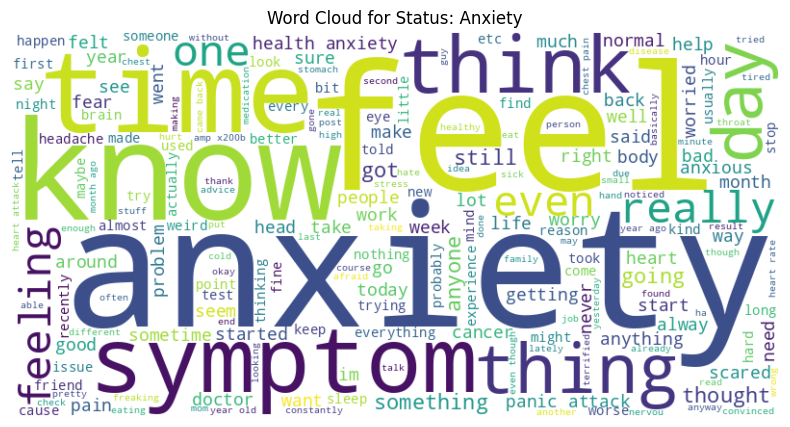

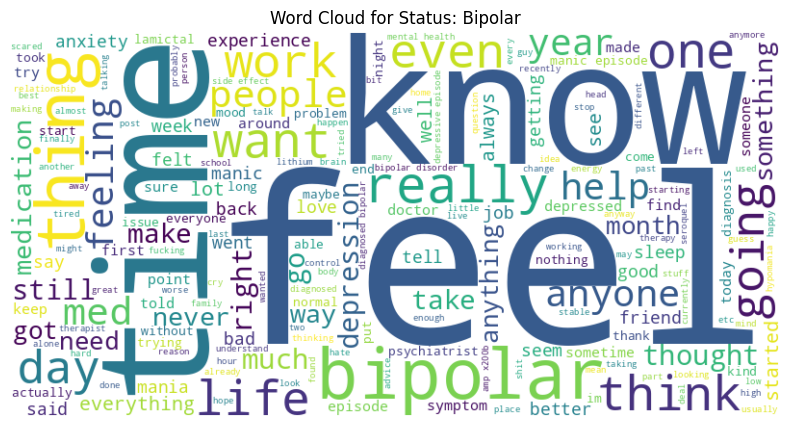

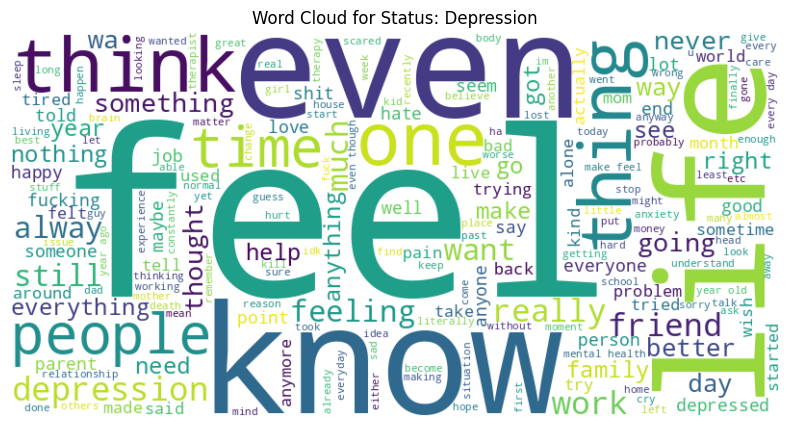

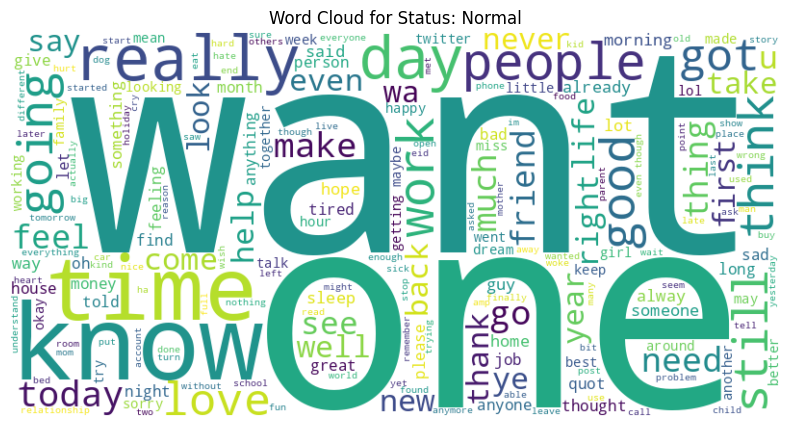

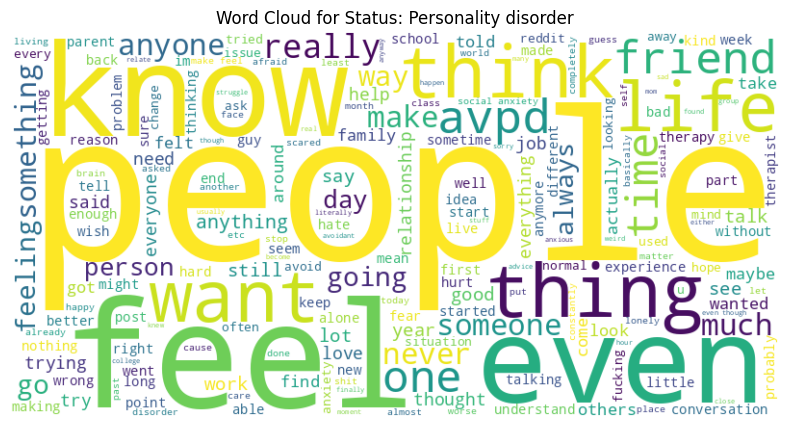

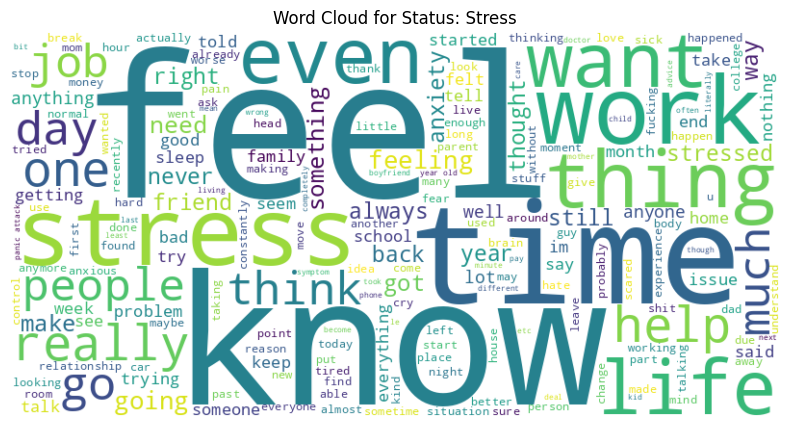

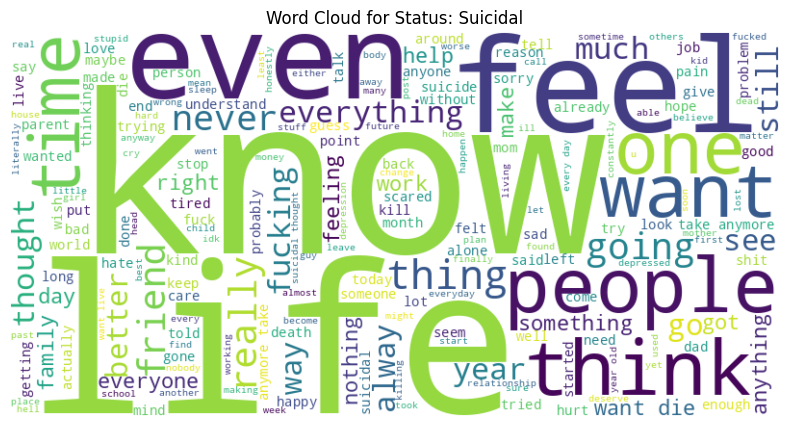

In [21]:

import matplotlib.pyplot as plt
# Group the DataFrame by 'status' and concatenate the 'processed_sentence' for each group
status_text = df.groupby('status')['processed_sentence'].apply(lambda x: ' '.join(x))

# Loop through each status and generate a word cloud
for status, text in status_text.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Status: {status}')
    plt.axis('off')
    plt.show()


# Data Preprocessing

In [22]:
# prompt: seperate text and label from dataset along with no_of_sentences,no_of_characters

X = df[['processed_sentence', 'len_of_sentences', 'len_characters']]
y = df['status']

In [23]:
X.shape, y.shape

((52681, 3), (52681,))

In [24]:
y.value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


In [25]:
print(isinstance(df['status'],pd.Series))

True


Label encoding to our target variable

In [26]:
le = LabelEncoder()
y = le.fit_transform(y)

In [27]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((42144, 3), (10537, 3), (42144,), (10537,))

In [ ]:
X_train

,processed_sentence,len_of_sentences,len_characters
5764,turn wake jihoon dream,1,41
24392,rejected dumped many time hurt anymore fuel su...,1,499
21683,scared get med even though know many option le...,2,189
36317,haha well never permanent state offline,1,71
7991,struggled depression many year go strategy get...,6,591
...,...,...,...
5703,girlfromnowherenetflix season 2 bit twist yuri...,1,110
8016,feel like open anybody anymore treated telling...,9,935
17755,surprisingly good anything try get smacked oth...,5,895
17941,best possibly nothing look good psychiatrist k...,1,535


In [ ]:
y_train

array([3, 2, 2, ..., 6, 2, 1])

# Convert text to features using TF-IDF vectoriser

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_train = tfidf_vectorizer.fit_transform(X_train['processed_sentence'])
tfidf_test = tfidf_vectorizer.transform(X_test['processed_sentence'])

In [29]:
numerical_features_train = X_train[['len_of_sentences', 'len_characters']]
numerical_features_test = X_test[['len_of_sentences', 'len_characters']]

X_train_combined = hstack((tfidf_train, numerical_features_train))
X_test_combined = hstack((tfidf_test, numerical_features_test))

In [30]:
X_train_combined.shape, X_test_combined.shape

((42144, 5002), (10537, 5002))

In [31]:
print("Number of feature words:", len(tfidf_vectorizer.get_feature_names_out()))

Number of feature words: 5000




```
# This is formatted as code
```

# Resampling target :
 since target is imbalanced data we have to resample it

In [34]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)
print("Original dataset shape:", y_train.shape)
print("Resampled dataset shape:", y_train_resampled.shape)
X_train_resampled.shape, X_test_combined.shape, y_train_resampled.shape, y_test.shape

Original dataset shape: (42144,)
Resampled dataset shape: (91742,)


((91742, 5002), (10537, 5002), (91742,), (10537,))

# Model Training and Evaluation

In [36]:
#Define different classifiers with hyperparameters
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# Hyperparameter grid for each classifier
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2']
    },
    "Bernoulli Naive Bayes": {
        'alpha': [0.1, 1.0]
    },
    "Decision Tree": {
        'max_depth': [5, 10],
        'min_samples_split': [5, 10]
    },
    "XGBoost": {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3, 5]
    }
}

# Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}



For Logistic Regression
Accuracy: 0.4051
ROC AUC Score: 0.7135
                      precision    recall  f1-score   support

             Anxiety       0.36      0.01      0.01       768
             Bipolar       0.16      0.18      0.17       566
          Depression       0.51      0.31      0.39      3050
              Normal       0.74      0.72      0.73      3237
Personality disorder       0.06      0.39      0.10       202
              Stress       0.02      0.05      0.03       530
            Suicidal       0.35      0.35      0.35      2184

            accuracy                           0.41     10537
           macro avg       0.31      0.29      0.26     10537
        weighted avg       0.48      0.41      0.42     10537



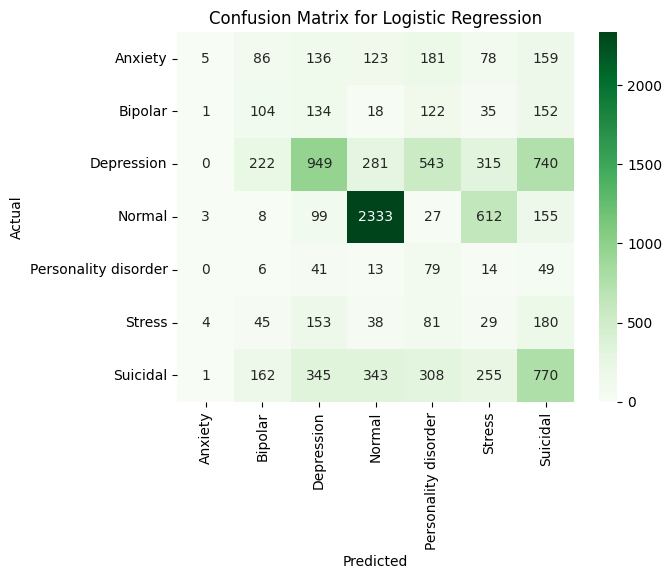


For Bernoulli Naive Bayes
Accuracy: 0.5941
ROC AUC Score: 0.8706
                      precision    recall  f1-score   support

             Anxiety       0.68      0.55      0.61       768
             Bipolar       0.54      0.60      0.57       566
          Depression       0.66      0.35      0.46      3050
              Normal       0.66      0.92      0.77      3237
Personality disorder       0.35      0.51      0.41       202
              Stress       0.30      0.55      0.39       530
            Suicidal       0.56      0.48      0.52      2184

            accuracy                           0.59     10537
           macro avg       0.54      0.57      0.53     10537
        weighted avg       0.61      0.59      0.58     10537



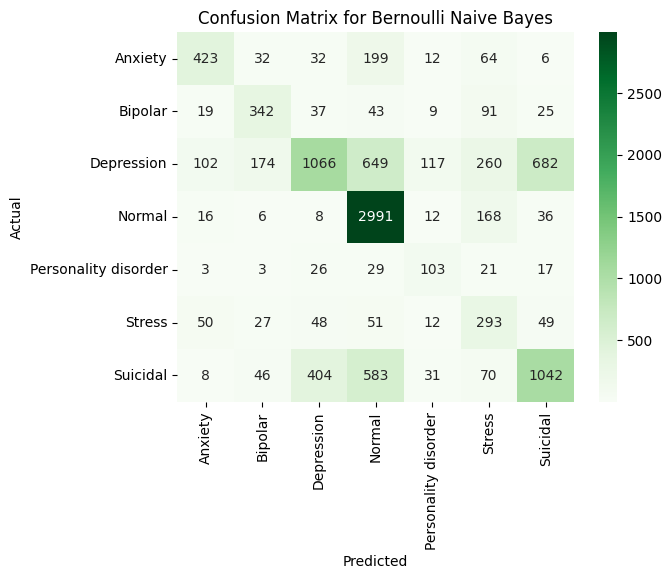


For Decision Tree
Accuracy: 0.6471
ROC AUC Score: 0.7700
                      precision    recall  f1-score   support

             Anxiety       0.62      0.64      0.63       768
             Bipolar       0.60      0.61      0.61       566
          Depression       0.60      0.57      0.59      3050
              Normal       0.86      0.86      0.86      3237
Personality disorder       0.43      0.53      0.48       202
              Stress       0.44      0.53      0.48       530
            Suicidal       0.50      0.49      0.49      2184

            accuracy                           0.65     10537
           macro avg       0.58      0.60      0.59     10537
        weighted avg       0.65      0.65      0.65     10537



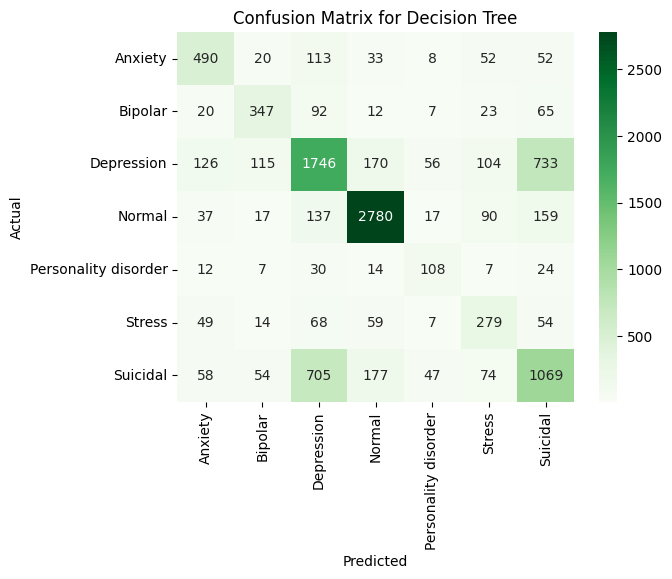


For XGBoost
Accuracy: 0.7595
ROC AUC Score: 0.9496
                      precision    recall  f1-score   support

             Anxiety       0.78      0.83      0.80       768
             Bipolar       0.77      0.80      0.78       566
          Depression       0.77      0.64      0.70      3050
              Normal       0.90      0.90      0.90      3237
Personality disorder       0.59      0.66      0.62       202
              Stress       0.48      0.78      0.59       530
            Suicidal       0.66      0.69      0.67      2184

            accuracy                           0.76     10537
           macro avg       0.71      0.76      0.72     10537
        weighted avg       0.77      0.76      0.76     10537



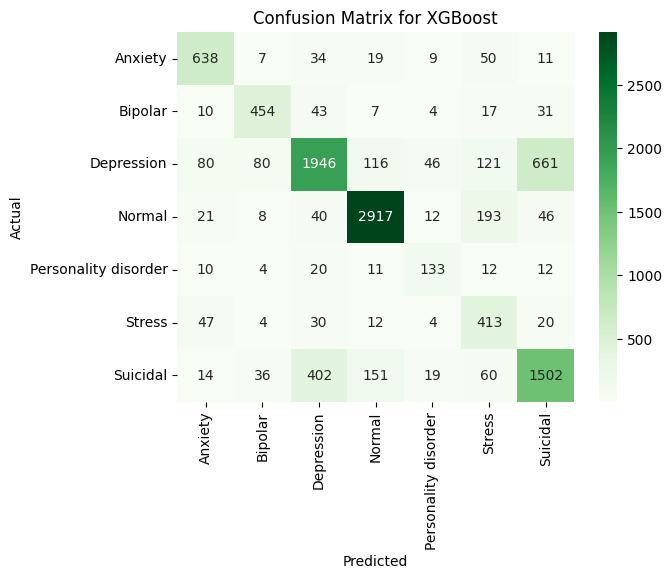

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Initialize lists to store accuracy and ROC AUC scores for each classifier
accuracy_scores = []
roc_auc_scores = []
classifier_names = []

# Iterate over each classifier and its name in the classifiers dictionary
for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test_combined)

    # Check if the problem is binary or multiclass
    if len(le.classes_) == 2:
        y_pred_proba = clf.predict_proba(X_test_combined)[:, 1]  # Get the probability estimates for the positive class
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        y_pred_proba = clf.predict_proba(X_test_combined)
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # Use 'ovr' for multiclass

    accuracy = accuracy_score(y_test, y_pred)

    print(f"\nFor {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Compute the confusion matrix for the predictions
    labels = le.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))

    # Plot the confusion matrix using a heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Append the accuracy and ROC AUC scores to the lists
    accuracy_scores.append(accuracy)
    roc_auc_scores.append(roc_auc)
    classifier_names.append(name)

for our data set XGBoost classifier has performed well

In [40]:
import pickle
# Train the XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Save the trained XGBoost model using pickle
filename = 'xgb_model.pickle'
pickle.dump(xgb_model, open(filename, 'wb'))

# Save the label encoder
filename_le = 'label_encoder.pickle'
pickle.dump(le, open(filename_le, 'wb'))

# Save the TF-IDF vectorizer
filename_tfidf = 'tfidf_vectorizer.pickle'
pickle.dump(tfidf_vectorizer, open(filename_tfidf, 'wb'))
print("XGBoost model and Label Encoder saved successfully.")


XGBoost model and Label Encoder saved successfully.


In [52]:
import pandas as pd
import pickle
from scipy.sparse import hstack
# Load the saved XGBoost model
with open('/content/xgb_model.pickle', 'rb') as f:
    xgb_model = pickle.load(f)

# Load the saved label encoder
with open('/content/label_encoder.pickle', 'rb') as f:
    le = pickle.load(f)

# Load the saved TF-IDF vectorizer
with open('/content/tfidf_vectorizer.pickle', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)


def predict_new_text(new_text):
    # Preprocess the new text
    processed_text = textProcess(new_text)

    # Convert the preprocessed text to TF-IDF features
    tfidf_new = tfidf_vectorizer.transform([processed_text])

    # Extract numerical features (you might need to adjust this based on your feature engineering)
    numerical_features_new = pd.DataFrame({'len_of_sentences': [len(new_text.split('.'))], 'len_characters': [len(new_text)]})

    # Combine the TF-IDF and numerical features
    new_text_combined = hstack((tfidf_new, numerical_features_new))

    # Make predictions using the loaded model
    prediction = xgb_model.predict(new_text_combined)

    # Inverse transform the prediction to get the original label
    predicted_label = le.inverse_transform(prediction)[0]

    return predicted_label


# Example usage:
new_text = "your dream is not good."
predicted_label = predict_new_text(new_text)
print(f"Predicted label: {predicted_label}")


Predicted label: Normal


In [51]:
df.iloc[2000]

,2004
statement,your dream is not good
status,Normal
len_of_sentences,1
len_characters,22
processed_sentence,dream good
